<a href="https://colab.research.google.com/github/DaebeN/Console.Menu/blob/master/Klasifikasi_Sayur_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Masih Error
# Save the entire model
final_model_VGG16.save('my_model.h5')

from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('my_model.h5')


In [ ]:
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
%pip install split-folders
import splitfolders

os.mkdir('/tmp/images')

splitfolders.ratio('/content/gdrive/MyDrive/Dataset/Dataset Sayur', output="/tmp/images", seed=50, ratio=(0.8,0.1,0.1), group_prefix=None)

base_dir = '/tmp/images'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'val')

Copying files: 4545 files [01:32, 48.94 files/s] 


In [ ]:
#mengambil random image dari salah satu folder kelas
import random

train_image_dir = '/tmp/images/train/fresh_bitter_gourd'  # Path to your training images
image_files = os.listdir(train_image_dir)
random_image_file = random.choice(image_files)
random_image_path = os.path.join(train_image_dir, random_image_file)

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

image = load_img(random_image_path, target_size=(224, 224))  # Adjust target_size as needed
image_array = img_to_array(image)
image_array /= 255.0  # Normalize pixel values

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the input image size
input_size = (224, 224)
batch_size = 32
num_classes = 6

# Set the data directories
train_dir = '/tmp/images/train'
valid_dir = '/tmp/images/val'
test_dir = '/tmp/images/test'

In [ ]:
#VGG16
from tensorflow.keras.applications import VGG16

# Load the VGG16 model pretrained on ImageNet
model_VGG16 = VGG16(input_shape=(input_size[0], input_size[1], 3), include_top=False, weights='imagenet')

# Freeze the pretrained layers
for layer in model_VGG16.layers:
    layer.trainable = False

# Add custom classification layers on top of the pretrained model
flatten = tf.keras.layers.Flatten()(model_VGG16.output)
dense1 = tf.keras.layers.Dense(256, activation='relu')(flatten)
dropout = tf.keras.layers.Dropout(0.5)(dense1)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(dropout)

# Create the final model
final_model_VGG16 = tf.keras.Model(inputs=model_VGG16.input, outputs=output)

# Compile the model
final_model_VGG16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
layer_outputs = [layer.output for layer in final_model_VGG16.layers if 'conv' in layer.name][:3]  # Select first 3 convolutional layers
activation_model = tf.keras.Model(inputs=final_model_VGG16.input, outputs=layer_outputs)
activations = activation_model.predict(np.expand_dims(image_array, axis=0))

1/1 [==============================] - 2s 2s/step


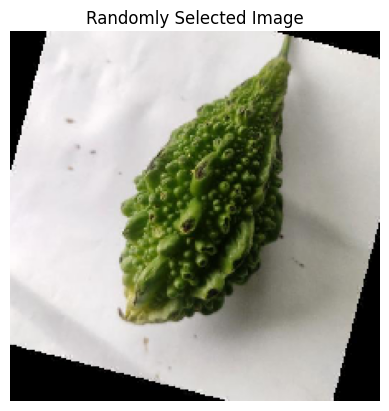

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# ... (Previous code for selecting random image and loading it) ...

# Display the image
plt.imshow(image)
plt.title('Randomly Selected Image')
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
#VGG16
from tensorflow.keras.applications import VGG16

# Load the VGG16 model pretrained on ImageNet
model_VGG16 = VGG16(input_shape=(input_size[0], input_size[1], 3), include_top=False, weights='imagenet')

# Freeze the pretrained layers
for layer in model_VGG16.layers:
    layer.trainable = False

# Add custom classification layers on top of the pretrained model
flatten = tf.keras.layers.Flatten()(model_VGG16.output) #multi dimension array > array 1D
dense1 = tf.keras.layers.Dense(256, activation='relu')(flatten) #if x positive then x=x, if x negative then x=0 #dense used to process the end of neural and make prediction
dropout = tf.keras.layers.Dropout(0.5)(dense1)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(dropout) #Softmax mengonversi nilai dari setiap neuron menjadi probabilitas yang berjumlah satu

# Create the final model
final_model_VGG16 = tf.keras.Model(inputs=model_VGG16.input, outputs=output)

# Compile the model
final_model_VGG16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data preprocessing
data_generator = ImageDataGenerator(rescale=1./255)

# Load and preprocess the training set
train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load and preprocess the validation set
valid_generator = data_generator.flow_from_directory(
    valid_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load and preprocess the test set
test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# Calculate the total number of batches in one epoch for training and validation
train_steps_per_epoch = len(train_generator)
valid_steps_per_epoch = len(valid_generator)

# Train the model with early stopping
history = final_model_VGG16.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,
    validation_data=valid_generator,
    validation_steps=valid_steps_per_epoch,
    callbacks=[early_stopping]
)


# Evaluate the model on the test set
y_pred = final_model_VGG16.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Calculate metrics
print('Classification Report:')
print(classification_report(y_true, y_pred))

58889256/58889256 [==============================] - 2s 0us/step
Found 3633 images belonging to 6 classes.
Found 452 images belonging to 6 classes.
Found 460 images belonging to 6 classes.
Epoch 1/10
114/114 [==============================] - 32s 189ms/step - loss: 1.1880 - accuracy: 0.6435 - val_loss: 0.3065 - val_accuracy: 0.9181
Epoch 2/10
114/114 [==============================] - 16s 138ms/step - loss: 0.3475 - accuracy: 0.8618 - val_loss: 0.1662 - val_accuracy: 0.9646
Epoch 3/10
114/114 [==============================] - 16s 141ms/step - loss: 0.2213 - accuracy: 0.9163 - val_loss: 0.1005 - val_accuracy: 0.9823
Epoch 4/10
114/114 [==============================] - 17s 146ms/step - loss: 0.1785 - accuracy: 0.9323 - val_loss: 0.0652 - val_accuracy: 0.9956
Epoch 5/10
114/114 [==============================] - 17s 151ms/step - loss: 0.1362 - accuracy: 0.9452 - val_loss: 0.0590 - val_accuracy: 0.9934
Epoch 6/10
114/114 [==============================] - 17s 149ms/step - loss: 0.1347 - 

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print confusion matrix
print('Confusion Matrix:')
print(cm)

Confusion Matrix:
[[34  0  0  0  0  0]
 [ 0 98  0  0  1  0]
 [ 0  0 99  0  0  0]
 [ 0  0  0 37  0  0]
 [ 0  0  0  0 92  0]
 [ 0  0 15  0  0 84]]


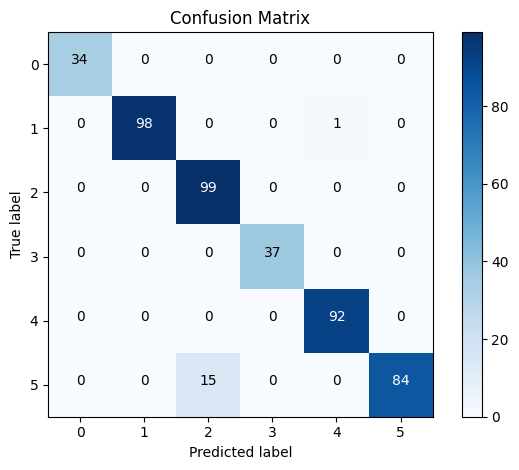

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels for the axes
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))

# Add labels for each cell
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [ ]:
#VGG19
from tensorflow.keras.applications import VGG19

# Load the VGG19 model pretrained on ImageNet
model_VGG19 = VGG19(input_shape=(input_size[0], input_size[1], 3), include_top=False, weights='imagenet')

# Freeze the pretrained layers
for layer in model_VGG19.layers:
    layer.trainable = False

# Add custom classification layers on top of the pretrained model
flatten = tf.keras.layers.Flatten()(model_VGG19.output)
dense1 = tf.keras.layers.Dense(256, activation='relu')(flatten)
dropout = tf.keras.layers.Dropout(0.5)(dense1)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(dropout)

# Create the final model
final_model_VGG19 = tf.keras.Model(inputs=model_VGG19.input, outputs=output)

# Compile the model
final_model_VGG19.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data preprocessing
data_generator = ImageDataGenerator(rescale=1./255)

# Load and preprocess the training set
train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load and preprocess the validation set
valid_generator = data_generator.flow_from_directory(
    valid_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load and preprocess the test set
test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# Calculate the total number of batches in one epoch for training and validation
train_steps_per_epoch = len(train_generator)
valid_steps_per_epoch = len(valid_generator)

# Train the model with early stopping
history = final_model_VGG19.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,
    validation_data=valid_generator,
    validation_steps=valid_steps_per_epoch,
    callbacks=[early_stopping]
)


# Evaluate the model on the test set
y_pred = final_model_VGG19.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Calculate metrics
print('Classification Report:')
print(classification_report(y_true, y_pred))

80134624/80134624 [==============================] - 3s 0us/step
Found 3633 images belonging to 6 classes.
Found 452 images belonging to 6 classes.
Found 460 images belonging to 6 classes.
Epoch 1/10
114/114 [==============================] - 22s 182ms/step - loss: 1.2465 - accuracy: 0.6053 - val_loss: 0.4130 - val_accuracy: 0.8496
Epoch 2/10
114/114 [==============================] - 21s 184ms/step - loss: 0.4639 - accuracy: 0.8109 - val_loss: 0.2450 - val_accuracy: 0.9336
Epoch 3/10
114/114 [==============================] - 20s 178ms/step - loss: 0.3417 - accuracy: 0.8665 - val_loss: 0.1487 - val_accuracy: 0.9757
Epoch 4/10
114/114 [==============================] - 20s 176ms/step - loss: 0.2850 - accuracy: 0.8962 - val_loss: 0.1143 - val_accuracy: 0.9735
Epoch 5/10
114/114 [==============================] - 20s 176ms/step - loss: 0.2710 - accuracy: 0.8949 - val_loss: 0.1055 - val_accuracy: 0.9735
Epoch 6/10
114/114 [==============================] - 21s 180ms/step - loss: 0.2252 - 

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print confusion matrix
print('Confusion Matrix:')
print(cm)

Confusion Matrix:
[[34  0  0  0  0  0]
 [ 0 98  0  0  1  0]
 [ 0  0 97  0  0  2]
 [ 0  0  0 37  0  0]
 [ 0  0  0  0 92  0]
 [ 0  0  8  0  0 91]]


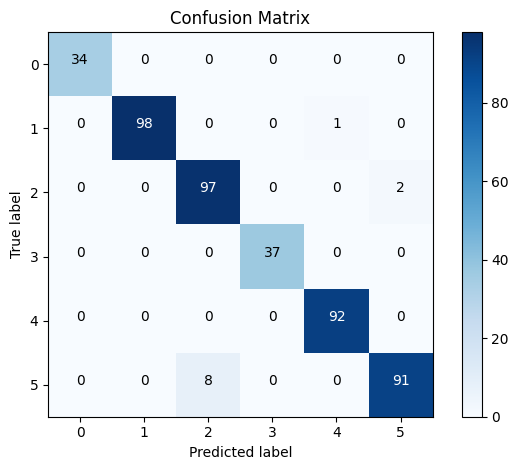

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels for the axes
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))

# Add labels for each cell
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [ ]:
#ResNet50
from tensorflow.keras.applications import ResNet50

# Load the ResNet50 model pretrained on ImageNet
model_ResNet50 = ResNet50(input_shape=(input_size[0], input_size[1], 3), include_top=False, weights='imagenet')

# Freeze the pretrained layers
for layer in model_ResNet50.layers:
    layer.trainable = False

# Add custom classification layers on top of the pretrained model
flatten = tf.keras.layers.Flatten()(model_ResNet50.output)
dense1 = tf.keras.layers.Dense(256, activation='relu')(flatten)
dropout = tf.keras.layers.Dropout(0.5)(dense1)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(dropout)

# Create the final model
final_model_ResNet50 = tf.keras.Model(inputs=model_ResNet50.input, outputs=output)

# Compile the model
final_model_ResNet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data preprocessing
data_generator = ImageDataGenerator(rescale=1./255)

# Load and preprocess the training set
train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load and preprocess the validation set
valid_generator = data_generator.flow_from_directory(
    valid_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load and preprocess the test set
test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# Calculate the total number of batches in one epoch for training and validation
train_steps_per_epoch = len(train_generator)
valid_steps_per_epoch = len(valid_generator)

# Train the model with early stopping
history = final_model_ResNet50.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=30,
    validation_data=valid_generator,
    validation_steps=valid_steps_per_epoch,
    callbacks=[early_stopping]
)


# Evaluate the model on the test set
y_pred = final_model_ResNet50.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Calculate metrics
print('Classification Report:')
print(classification_report(y_true, y_pred))

94765736/94765736 [==============================] - 4s 0us/step
Found 3633 images belonging to 6 classes.
Found 452 images belonging to 6 classes.
Found 460 images belonging to 6 classes.
Epoch 1/30
114/114 [==============================] - 25s 159ms/step - loss: 2.3689 - accuracy: 0.2326 - val_loss: 1.7144 - val_accuracy: 0.3761
Epoch 2/30
114/114 [==============================] - 15s 128ms/step - loss: 1.7487 - accuracy: 0.2307 - val_loss: 1.7531 - val_accuracy: 0.2168
Epoch 3/30
114/114 [==============================] - 15s 127ms/step - loss: 1.7499 - accuracy: 0.2158 - val_loss: 1.7390 - val_accuracy: 0.2168
Epoch 4/30
114/114 [==============================] - 15s 127ms/step - loss: 1.7346 - accuracy: 0.2158 - val_loss: 1.7286 - val_accuracy: 0.2168
Epoch 4: early stopping
15/15 [==============================] - 4s 203ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print confusion matrix
print('Confusion Matrix:')
print(cm)

Confusion Matrix:
[[ 0  0 34  0  0  0]
 [ 0  0 99  0  0  0]
 [ 0  0 99  0  0  0]
 [ 0  0 37  0  0  0]
 [ 0  0 92  0  0  0]
 [ 0  0 99  0  0  0]]


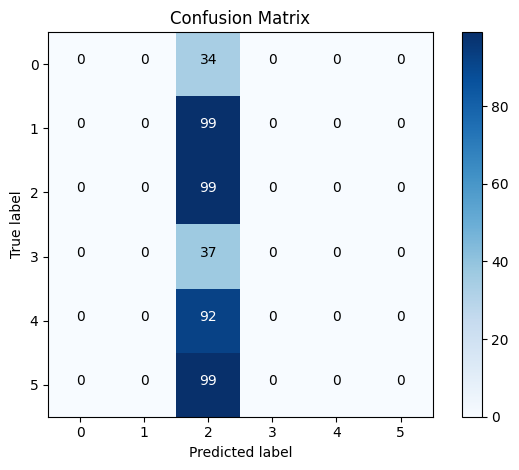

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels for the axes
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))

# Add labels for each cell
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()